InSAR Coherence generation with MintPy

In [13]:
## RANDOM TEST TO CHECK ISCE INSTALLATION ##
#import sys
#import os

## Check if isce is importable
#import isce

#print(f"ISCE found at: {isce.__file__}")

# Check if command line tools are found
#!which topsApp.py

Imports and setup

In [14]:
import os
import sys
import isce
import shutil

# --- CONFIGURATION ---
PROJECT_DIR = "/home/st-juho/code_testing"
os.chdir(PROJECT_DIR)

# 1. Find ISCE installation path dynamically
isce_home = os.path.dirname(isce.__file__)

# 2. Locate topsApp.py
# Check standard location in env39
TOPSAPP = os.path.join(isce_home, 'applications', 'topsApp.py')

if not os.path.exists(TOPSAPP):
    # Fallback: Check conda bin
    TOPSAPP = os.path.join(os.path.dirname(sys.executable), 'topsApp.py')

print(f"Current Working Directory: {os.getcwd()}")
print(f"Python Executable: {sys.executable}")

if os.path.exists(TOPSAPP):
    print(f"✅ Found topsApp.py at: {TOPSAPP}")
else:
    print("❌ CRITICAL: Could not find topsApp.py. Is 'env39' active?")

Current Working Directory: /home/st-juho/code_testing
Python Executable: /home/st-juho/code_testing/miniconda3/envs/env39/bin/python
✅ Found topsApp.py at: /home/st-juho/code_testing/miniconda3/envs/env39/lib/python3.9/site-packages/isce/applications/topsApp.py


Define Sentinel-1 SAR inputs

In [15]:
# --- INPUTS ---
# The July 2017 scene (New Download) -> Master (Reference)
master_path = "/home/st-juho/code_testing/S1B_IW_SLC__1SDV_20170725T122204_20170725T122234_006644_00BAFB_0D34.SAFE"

# The August 2017 scene (Previous Slave) -> Slave (Secondary)
slave_path  = "/home/st-juho/code_testing/S1B_IW_SLC__1SDV_20170830T122203_20170830T122233_007169_00CA2C_C92C.SAFE"

# Check if they exist
if not os.path.isdir(master_path):
    raise FileNotFoundError(f"❌ Master not found: {master_path}")
if not os.path.isdir(slave_path):
    raise FileNotFoundError(f"❌ Slave not found: {slave_path}")

print(f"Reference (Master): {os.path.basename(master_path)}")
print(f"Secondary (Slave):  {os.path.basename(slave_path)}")

Reference (Master): S1B_IW_SLC__1SDV_20170725T122204_20170725T122234_006644_00BAFB_0D34.SAFE
Secondary (Slave):  S1B_IW_SLC__1SDV_20170830T122203_20170830T122233_007169_00CA2C_C92C.SAFE


Geometry check

In [16]:
def get_metadata(safe_path):
    manifest = os.path.join(safe_path, "manifest.safe")
    direction = "Unknown"
    track = "Unknown"
    with open(manifest, 'r') as f:
        for line in f:
            # Look for Pass Direction
            if "pass" in line.lower() and "sc:value" not in line:
                if "Ascending" in line: direction = "ASCENDING"
                if "Descending" in line: direction = "DESCENDING"
            # Look for Relative Orbit (Track)
            if "relativeOrbitNumber" in line:
                try:
                    track = line.split('>')[1].split('<')[0]
                except: pass
    return direction, track

m_dir, m_track = get_metadata(master_path)
s_dir, s_track = get_metadata(slave_path)

print(f"Master: {m_dir} (Track {m_track})")
print(f"Slave:  {s_dir} (Track {s_track})")

if m_dir != s_dir:
    raise ValueError("❌ STOP: Pass directions do not match! You cannot interfere Ascending with Descending.")
if m_track != s_track:
    print("⚠️ WARNING: Tracks do not match. If they are adjacent, this might fail. Ideally tracks should match.")
else:
    print("✅ GEOMETRY MATCH: Safe to proceed.")

Master: Unknown (Track 143)
Slave:  Unknown (Track 143)
✅ GEOMETRY MATCH: Safe to proceed.


Config file for ISCE2

Get orbit files

In [17]:
import os
import requests
import netrc

# --- CONFIGURATION ---
# The exact files ISCE requested (from your logs)
files_to_download = [
    "S1B_OPER_AUX_POEORB_OPOD_20170814T111246_V20170724T225942_20170726T005942.EOF",
    "S1B_OPER_AUX_POEORB_OPOD_20170919T111338_V20170829T225942_20170831T005942.EOF"
]

# Define path
orbit_dir = os.path.join(PROJECT_DIR, 'orbits')
if not os.path.exists(orbit_dir):
    os.makedirs(orbit_dir)

# --- 1. GET CREDENTIALS FROM .NETRC ---
try:
    # This reads ~/.netrc
    secrets = netrc.netrc()
    # Look for the Earthdata login
    auth_tuple = secrets.authenticators("urs.earthdata.nasa.gov")
    if not auth_tuple:
        # Fallback to generic if specific host not found
        auth_tuple = secrets.authenticators("earthdata.nasa.gov")
    
    if auth_tuple:
        username, _, password = auth_tuple
        print(f"✅ Found credentials for user: {username}")
    else:
        raise ValueError("No credentials found in ~/.netrc for earthdata!")
        
except Exception as e:
    print(f"❌ .netrc Error: {e}")
    print("Please ensure ~/.netrc exists and has permissions 600.")
    # Stop here if no auth
    username = None
    password = None

# --- 2. DOWNLOAD LOOP ---
if username:
    # We use a session to handle cookies/redirects
    session = requests.Session()
    session.auth = (username, password)
    
    for filename in files_to_download:
        url = f"https://s1qc.asf.alaska.edu/aux_poeorb/{filename}"
        dest_path = os.path.join(orbit_dir, filename)
        
        print(f"\n⬇️ Attempting download: {filename}")
        
        try:
            response = session.get(url, stream=True)
            
            if response.status_code == 200:
                # Check if it's actually XML and not an HTML error page
                content_type = response.headers.get('content-type', '')
                
                if "text/html" in content_type:
                     print("❌ Error: Server returned HTML (Login Page) instead of XML file.")
                else:
                    with open(dest_path, 'wb') as f:
                        for chunk in response.iter_content(chunk_size=8192):
                            f.write(chunk)
                    print("✅ Download Success!")
                    
                    # Verify XML Header
                    with open(dest_path, 'r') as f:
                        head = f.readline()
                    if "xml" in head.lower():
                        print("   (Verified valid XML structure)")
                    else:
                        print("   ⚠️ Warning: File header does not look like XML.")
            
            elif response.status_code == 404:
                print("❌ Error 404: File not found on ASF server.")
            elif response.status_code == 401:
                print("❌ Error 401: Unauthorized. Check your username/password.")
            else:
                print(f"❌ Failed with status code: {response.status_code}")
                
        except Exception as e:
            print(f"❌ Connection Error: {e}")

✅ Found credentials for user: juhoarjanne

⬇️ Attempting download: S1B_OPER_AUX_POEORB_OPOD_20170814T111246_V20170724T225942_20170726T005942.EOF
2025-11-25 16:13:50,373 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): s1qc.asf.alaska.edu:443


2025-11-25 16:13:51,339 - urllib3.connectionpool - DEBUG - https://s1qc.asf.alaska.edu:443 "GET /aux_poeorb/S1B_OPER_AUX_POEORB_OPOD_20170814T111246_V20170724T225942_20170726T005942.EOF HTTP/1.1" 302 145
2025-11-25 16:13:51,346 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): urs.earthdata.nasa.gov:443
2025-11-25 16:13:52,110 - urllib3.connectionpool - DEBUG - https://urs.earthdata.nasa.gov:443 "GET /oauth/authorize?response_type=code&client_id=BO_n7nTIlMljdvU6kRRB3g&redirect_uri=https://auth.asf.alaska.edu/login&state=https://s1qc.asf.alaska.edu/aux_poeorb/S1B_OPER_AUX_POEORB_OPOD_20170814T111246_V20170724T225942_20170726T005942.EOF&app_type=401 HTTP/1.1" 302 None
2025-11-25 16:13:52,122 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): auth.asf.alaska.edu:443
2025-11-25 16:13:53,524 - urllib3.connectionpool - DEBUG - https://auth.asf.alaska.edu:443 "GET /login?code=0JMKKBXJ7XPGtDtH_29qSk5gGIUMbeG6QOgl5AGRgbl6VcDZsjkb55bHBKsUVzjSGvDuUTpk0fk8HT2

ISCE2 Processing:

In [21]:
import shutil
import subprocess
import os
import sys

# --- 1. HARD RESET (REQUIRED) ---
# We must delete old folders so ISCE doesn't reuse the full-scene data
folders_to_wipe = ['reference', 'secondary', 'merged', 'pickle', 'fine_interferogram', 'geom_reference']
for folder in folders_to_wipe:
    if os.path.exists(folder):
        print(f"🗑️ Deleting old data: {folder}/")
        shutil.rmtree(folder)
if os.path.exists("topsApp.xml"):
    os.remove("topsApp.xml")

# --- 2. CONFIGURE WITH ROI ---
# East Houston ROI [South, North, West, East]
roi = [-95.708479,29.786186,-95.573593,29.873121]

topsApp_xml = f"""<?xml version="1.0" encoding="UTF-8"?>
<topsApp>
  <component name="topsinsar">
    <component name="reference">
      <property name="orbit directory">{os.path.join(PROJECT_DIR, 'orbits')}</property>
      <property name="auxiliary data directory">{os.path.join(PROJECT_DIR, 'aux')}</property>
      <property name="output directory">reference</property>
      <property name="safe">['{master_path}']</property>
    </component>
    <component name="secondary">
      <property name="orbit directory">{os.path.join(PROJECT_DIR, 'orbits')}</property>
      <property name="auxiliary data directory">{os.path.join(PROJECT_DIR, 'aux')}</property>
      <property name="output directory">secondary</property>
      <property name="safe">['{slave_path}']</property>
    </component>
    
    <!-- Process all swaths, ISCE will pick the one covering the ROI -->
    <property name="swaths">[1, 2, 3]</property>
    <property name="range looks">7</property>
    <property name="azimuth looks">3</property>
    <property name="do unwrap">False</property>
    
    <!-- THIS FORCES SUBSETTING -->
    <property name="region of interest">{roi}</property>
    
  </component>
</topsApp>
"""

with open("topsApp.xml", "w") as f:
    f.write(topsApp_xml)
print(f"✅ Configuration reset. ROI set to: {roi}")

# --- 3. RUN PROCESSING ---
# Clean env
my_env = os.environ.copy()
keys_to_kill = ['PYTHONPATH', 'ISCE_HOME', 'ISCE_ROOT']
for key in keys_to_kill:
    if key in my_env: del my_env[key]
current_site_packages = os.path.join(os.path.dirname(os.path.dirname(sys.executable)), 'lib', 'python3.9', 'site-packages')
my_env['PYTHONPATH'] = current_site_packages

command = f"{sys.executable} {TOPSAPP} topsApp.xml --start=startup --end=geocode"

print(f"🚀 Starting Fresh Processing (Subset)...")
process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, env=my_env)

while True:
    output = process.stdout.readline()
    if output == '' and process.poll() is not None:
        break
    if output:
        print(output.strip())

if process.returncode == 0:
    print("\n✅ Success! Processing finished on subset.")
else:
    print("\n❌ Failed.")

🗑️ Deleting old data: reference/
🗑️ Deleting old data: secondary/
🗑️ Deleting old data: merged/
🗑️ Deleting old data: fine_interferogram/
🗑️ Deleting old data: geom_reference/
✅ Configuration reset. ROI set to: [-95.708479, 29.786186, -95.573593, 29.873121]
🚀 Starting Fresh Processing (Subset)...
Using default ISCE Path: /home/st-juho/code_testing/miniconda3/envs/env39/lib/python3.9/site-packages/isce
2025-11-25 16:20:51,916 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION =
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION =
Step processing
Running step startup
None
The currently supported sensors are:  ['SENTINEL1']
Dumping the application's pickle object _insar to file  PICKLE/startup
The remaining steps are (in order):  ['preprocess', 'computeBaselines', 'verifyDEM', 'topo', 'subsetoverlaps', 'coarseoffsets', 'coarseresamp', 'overlapifg', 'prepesd', 'esd', 'rangecoreg', 'fineo

Visualize

Generating Map...
Running: view.py /home/st-juho/code_testing/merged/topophase.cor.geo --sub-lat 29.786186 29.873121 --sub-lon -95.708479 -95.573593 -c gray -v 0 1 --nodisplay -o coherence.png --title 'Coherence Map (East Houston)'
run view.py in MintPy version 1.6.2, date 2025-07-07
input file is isce .cor file: /home/st-juho/code_testing/merged/topophase.cor.geo in float32 format
file size in y/x: (3343, 6965)
num of datasets in file topophase.cor.geo: 2
datasets to exclude (0):
[]
datasets to display (2):
['band1', 'band2']
data   coverage in y/x: (0, 0, 6965, 3343)
subset coverage in y/x: (3296, 645, 3782, 958)
data   coverage in lat/lon: (-96.62430555555555, 30.05236111111111, -94.68958333333332, 29.123749999999998)
subset coverage in lat/lon: (-95.70875, 29.873194444444444, -95.57374999999999, 29.78625)
------------------------------------------------------------------------
colormap: gray
figure title: Coherence Map (East Houston)
figure size : [15.00, 8.00]
dataset number: 2
ro

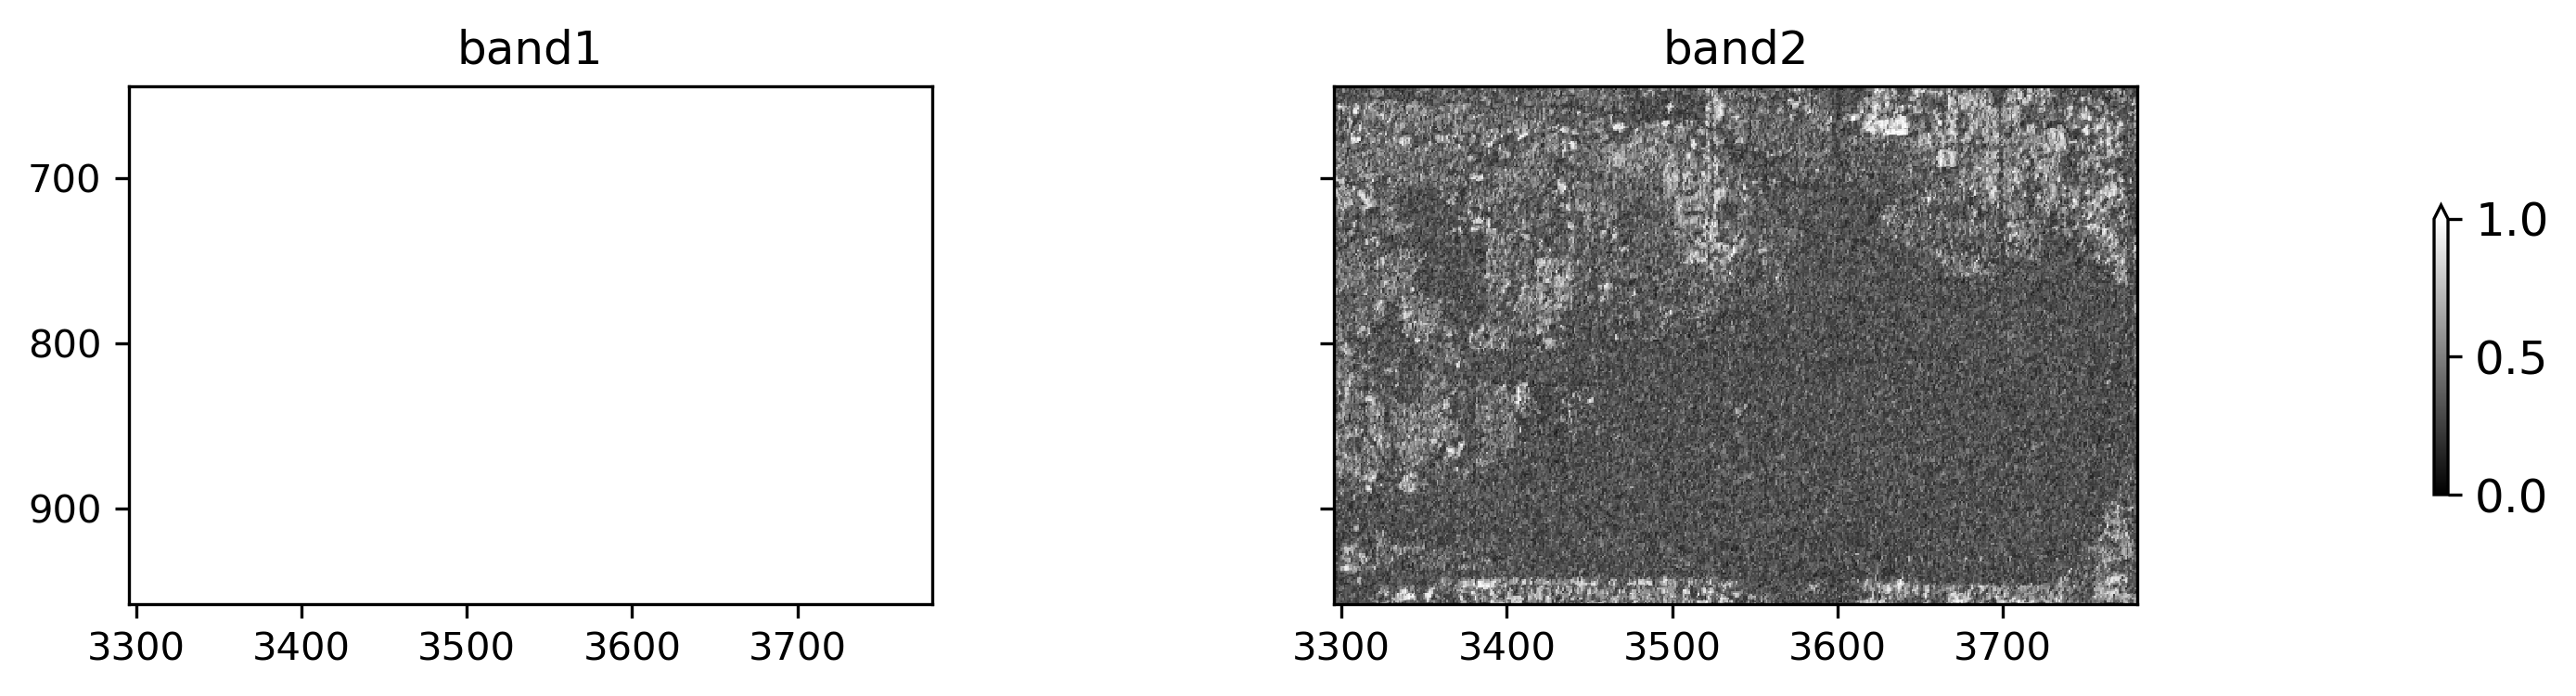

In [28]:
from mintpy.cli import view
from IPython.display import Image, display

# The output file from ISCE
geo_cor_file = os.path.join(PROJECT_DIR, "merged", "topophase.cor.geo")

if os.path.exists(geo_cor_file):
    print("Generating Map...")
    
    # Explicitly define the bounds for East Houston to avoid variable mix-ups
    # Order: South, North, West, East
    lat_min = 29.786186
    lat_max = 29.873121
    lon_min = -95.708479
    lon_max = -95.573593
    
    # Use --sub-lat (South North) and --sub-lon (West East)
    cmd = (f"{geo_cor_file} "
           f"--sub-lat {lat_min} {lat_max} --sub-lon {lon_min} {lon_max} "
           f"-c gray -v 0 1 --nodisplay -o coherence.png --title 'Coherence Map (East Houston)'")
    
    print(f"Running: view.py {cmd}")
    !view.py {cmd}
    
    # Show Image
    if os.path.exists("coherence.png"):
        display(Image(filename='coherence.png'))
    else:
        print("❌ Error: coherence.png was not created.")
else:
    print("❌ Output file# filepath: /home/st-juho/code_testing/insar_coherence.ipynb")
